In [14]:
# %pip install pandas numpy matplotlib scipy mpmath scikit-learn seaborn imbalanced-learn optuna

In [15]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import optuna
from scipy.stats import ttest_ind, chi2_contingency

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    roc_curve, 
    precision_recall_curve, 
    ConfusionMatrixDisplay, 
    RocCurveDisplay, 
    PrecisionRecallDisplay
)
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

In [16]:
CSV_PATH="data/WA_Fn-UseC_-Telco-Customer-Churn.csv"

In [17]:
df=pd.read_csv(CSV_PATH)

raw_df = df.copy()
raw_df["TotalCharges"] = pd.to_numeric(raw_df["TotalCharges"], errors="coerce")
raw_df.dropna(subset=["TotalCharges"], inplace=True)
# Convert 'Churn' column to numerical values
raw_df['Churn'] = raw_df['Churn'].map({'Yes': 1, 'No': 0})

display(raw_df.head())

display(raw_df.info())

display(raw_df.describe(include="all").T)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,0
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1


<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7032 non-null   object 
 1   gender            7032 non-null   object 
 2   SeniorCitizen     7032 non-null   int64  
 3   Partner           7032 non-null   object 
 4   Dependents        7032 non-null   object 
 5   tenure            7032 non-null   int64  
 6   PhoneService      7032 non-null   object 
 7   MultipleLines     7032 non-null   object 
 8   InternetService   7032 non-null   object 
 9   OnlineSecurity    7032 non-null   object 
 10  OnlineBackup      7032 non-null   object 
 11  DeviceProtection  7032 non-null   object 
 12  TechSupport       7032 non-null   object 
 13  StreamingTV       7032 non-null   object 
 14  StreamingMovies   7032 non-null   object 
 15  Contract          7032 non-null   object 
 16  PaperlessBilling  7032 non-null   object 
 17  

None

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
customerID,7032,7032,3186-AJIEK,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
gender,7032,2,Male,3549,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SeniorCitizen,7032.0,NaN,NaN,NaN,0.1624,0.368844,0.0,0.0,0.0,0.0,1.0
Partner,7032,2,No,3639,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Dependents,7032,2,No,4933,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tenure,7032.0,NaN,NaN,NaN,32.421786,24.54526,1.0,9.0,29.0,55.0,72.0
PhoneService,7032,2,Yes,6352,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MultipleLines,7032,3,No,3385,NaN,NaN,NaN,NaN,NaN,NaN,NaN
InternetService,7032,3,Fiber optic,3096,NaN,NaN,NaN,NaN,NaN,NaN,NaN
OnlineSecurity,7032,3,No,3497,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
CATEGORICAL_FEATURES=["gender", "SeniorCitizen", "Partner", "Dependents", "PhoneService", "MultipleLines", "InternetService", "OnlineSecurity", "OnlineBackup", "DeviceProtection", "TechSupport", "StreamingTV",
 "StreamingMovies", "Contract", "PaperlessBilling", "PaymentMethod", "Churn"]

for feature in CATEGORICAL_FEATURES:
    print(f"Unique Values for feature: {feature}\n{raw_df[feature].unique()}")
    print("="*100)

Unique Values for feature: gender
['Female' 'Male']
Unique Values for feature: SeniorCitizen
[0 1]
Unique Values for feature: Partner
['Yes' 'No']
Unique Values for feature: Dependents
['No' 'Yes']
Unique Values for feature: PhoneService
['No' 'Yes']
Unique Values for feature: MultipleLines
['No phone service' 'No' 'Yes']
Unique Values for feature: InternetService
['DSL' 'Fiber optic' 'No']
Unique Values for feature: OnlineSecurity
['No' 'Yes' 'No internet service']
Unique Values for feature: OnlineBackup
['Yes' 'No' 'No internet service']
Unique Values for feature: DeviceProtection
['No' 'Yes' 'No internet service']
Unique Values for feature: TechSupport
['No' 'Yes' 'No internet service']
Unique Values for feature: StreamingTV
['No' 'Yes' 'No internet service']
Unique Values for feature: StreamingMovies
['No' 'Yes' 'No internet service']
Unique Values for feature: Contract
['Month-to-month' 'One year' 'Two year']
Unique Values for feature: PaperlessBilling
['Yes' 'No']
Unique Values f

In [19]:
NUMERICAL_FEATURES = ["tenure", "MonthlyCharges", "TotalCharges"]

raw_df[NUMERICAL_FEATURES].describe(percentiles=[.01, .1, .25, .5, .75, .90, .95, .99]).T

,count,mean,std,min,1%,10%,25%,50%,75%,90%,95%,99%,max
tenure,7032.0,32.421786,24.545260,1.00,1.0,2.00,9.0000,29.000,55.0000,69.000,72.0000,72.0000,72.00
MonthlyCharges,7032.0,64.798208,30.085974,18.25,19.2,20.05,35.5875,70.350,89.8625,102.645,107.4225,114.7345,118.75
TotalCharges,7032.0,2283.300441,2266.771362,18.80,19.9,84.60,401.4500,1397.475,3794.7375,5976.640,6923.5900,8039.8830,8684.80


/tmp/ipykernel_36035/2738353549.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  churn, not_churn = raw_df.loc[raw_df['Churn']==True].count()[0], raw_df.loc[raw_df['Churn']==False].count()[0]
/tmp/ipykernel_36035/2738353549.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  churn, not_churn = raw_df.loc[raw_df['Churn']==True].count()[0], raw_df.loc[raw_df['Churn']==False].count()[0]


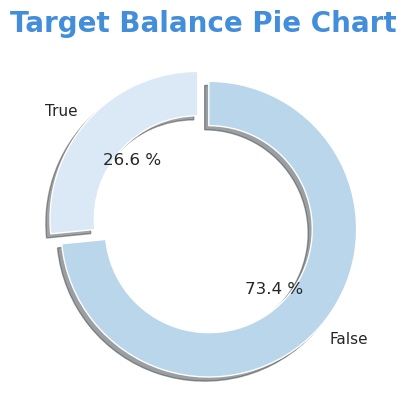

In [20]:
# Target Balance Visualization 
churn, not_churn = raw_df.loc[raw_df['Churn']==True].count()[0], raw_df.loc[raw_df['Churn']==False].count()[0]
labels = ['True', 'False']
colors = sns.color_palette('Blues')
explode = (.05, .05)

plt.title('Target Balance Pie Chart', loc='center', fontsize=20, color='#438EDB', fontweight='bold')
plt.pie(
    (churn, not_churn),
    labels=labels, colors=colors,
    autopct='%.1f %%', explode=explode, shadow=True,
    startangle=90, wedgeprops={'width':0.3}
)
plt.show()

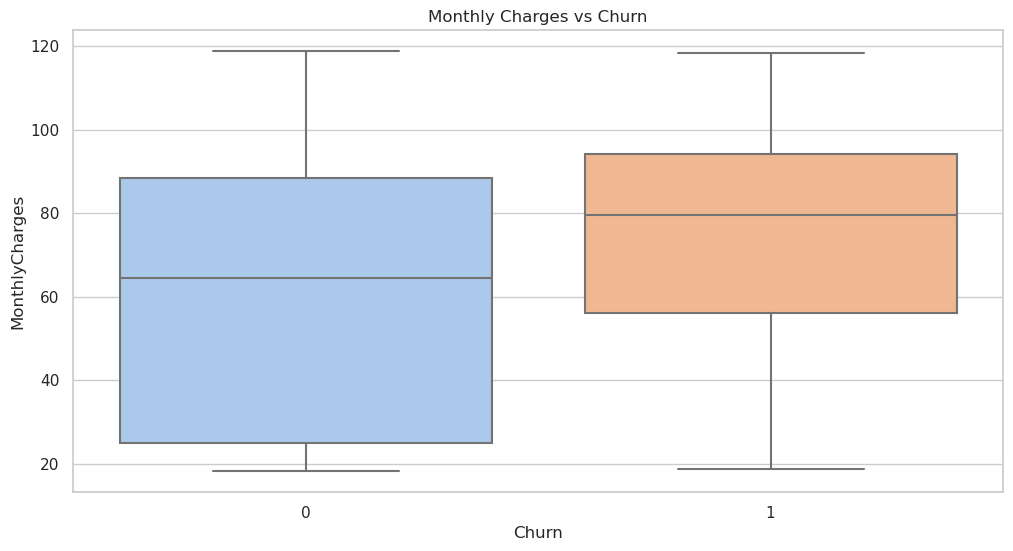

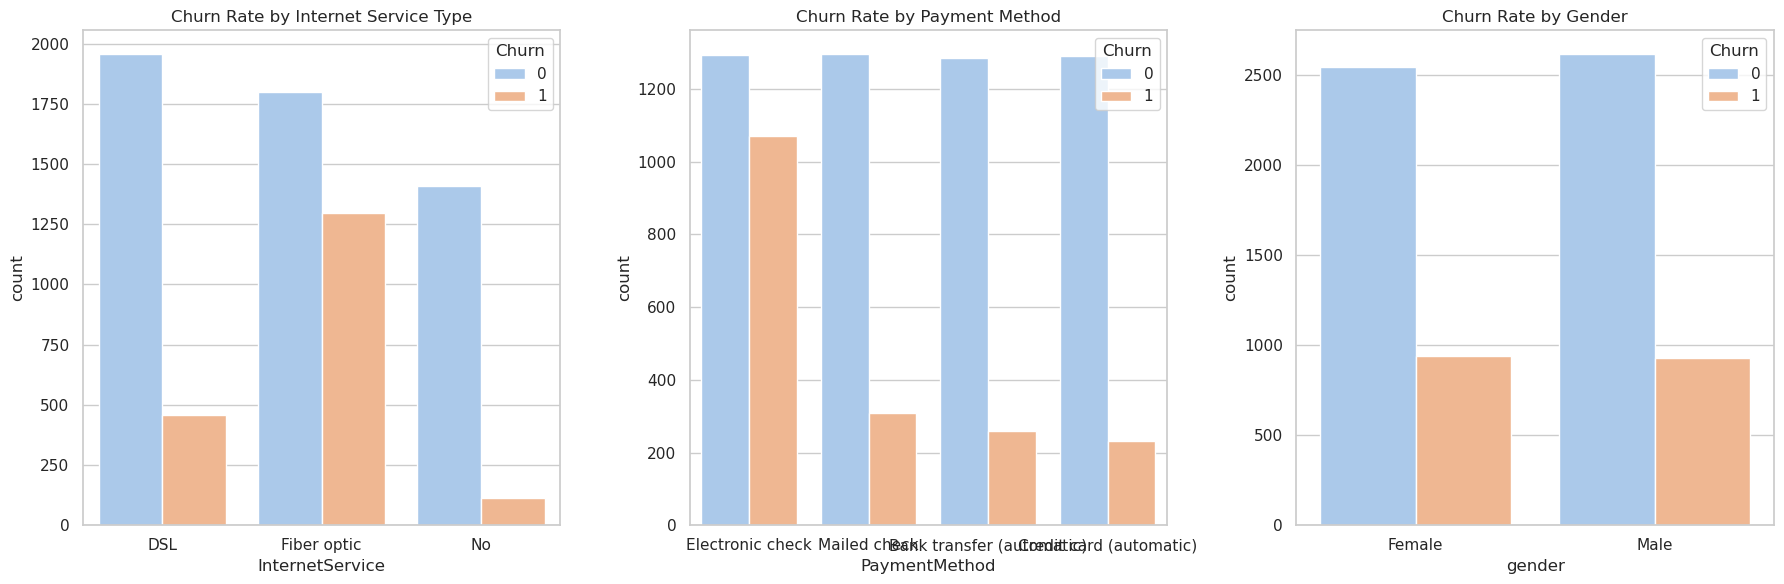

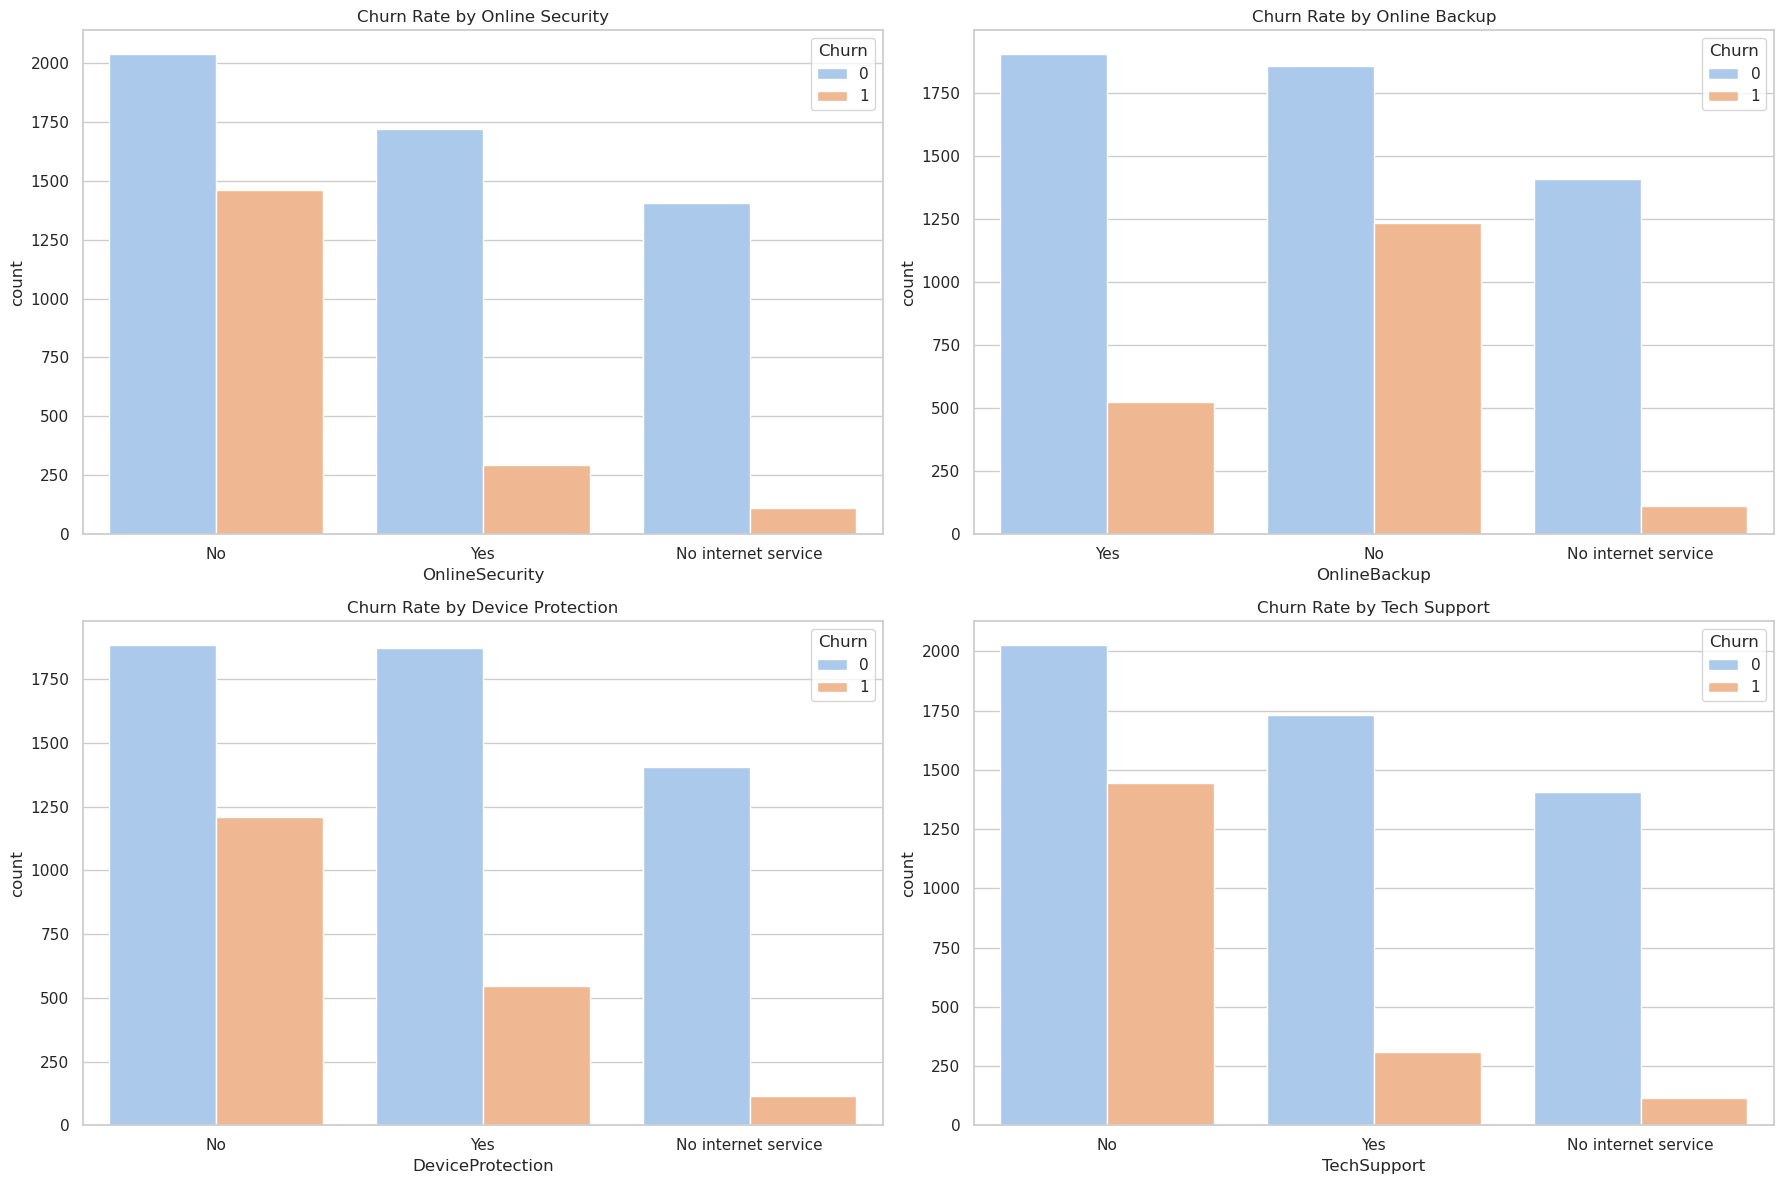

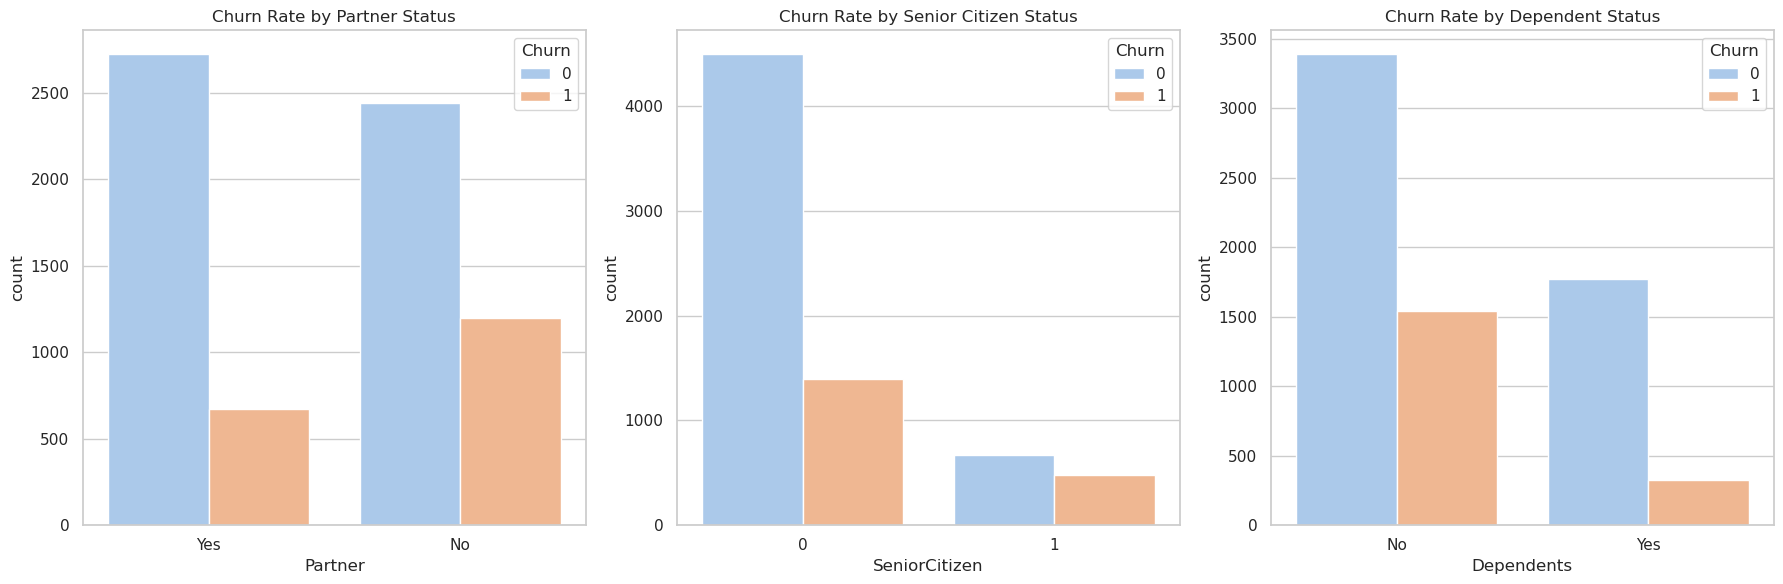

/home/andrea/anaconda3/envs/AI-Comm-Mark/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/andrea/anaconda3/envs/AI-Comm-Mark/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/andrea/anaconda3/envs/AI-Comm-Mark/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/andrea/anaconda3/envs/AI-Comm-Mark/lib/python3.11/site-packages/seab

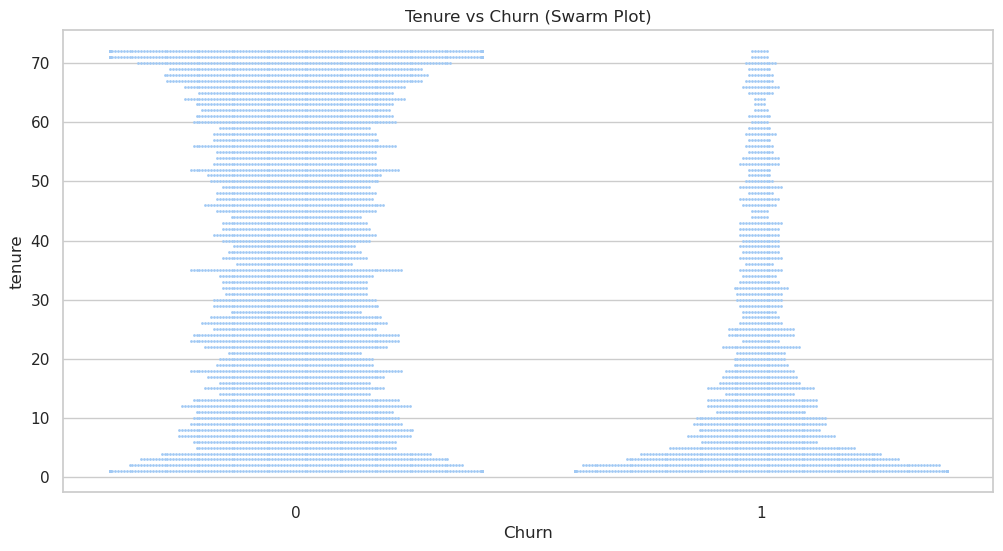

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# Setting the overall aesthetics
sns.set(style="whitegrid", palette="pastel")

# Plot 1: Monthly Charges vs Churn
plt.figure(figsize=(12, 6))
sns.boxplot(x='Churn', y='MonthlyCharges', data=raw_df)
plt.title('Monthly Charges vs Churn')
plt.show()

# Plot 2: Churn Rate by Internet Service, Payment Method, and Gender
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
sns.countplot(x='InternetService', hue='Churn', data=raw_df, ax=axes[0])
axes[0].set_title('Churn Rate by Internet Service Type')
sns.countplot(x='PaymentMethod', hue='Churn', data=raw_df, ax=axes[1])
axes[1].set_title('Churn Rate by Payment Method')
sns.countplot(x='gender', hue='Churn', data=raw_df, ax=axes[2])
axes[2].set_title('Churn Rate by Gender')
plt.tight_layout()
plt.show()

# Plot 3: Impact of Online Security, Online Backup, Device Protection, and Tech Support on Churn Rate
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
sns.countplot(x='OnlineSecurity', hue='Churn', data=raw_df, ax=axes[0, 0])
axes[0, 0].set_title('Churn Rate by Online Security')
sns.countplot(x='OnlineBackup', hue='Churn', data=raw_df, ax=axes[0, 1])
axes[0, 1].set_title('Churn Rate by Online Backup')
sns.countplot(x='DeviceProtection', hue='Churn', data=raw_df, ax=axes[1, 0])
axes[1, 0].set_title('Churn Rate by Device Protection')
sns.countplot(x='TechSupport', hue='Churn', data=raw_df, ax=axes[1, 1])
axes[1, 1].set_title('Churn Rate by Tech Support')
plt.tight_layout()
plt.show()

# Plot 4: Influence of Partner, Senior Citizen, or Dependent on Churn Rate
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
sns.countplot(x='Partner', hue='Churn', data=raw_df, ax=axes[0])
axes[0].set_title('Churn Rate by Partner Status')
sns.countplot(x='SeniorCitizen', hue='Churn', data=raw_df, ax=axes[1])
axes[1].set_title('Churn Rate by Senior Citizen Status')
sns.countplot(x='Dependents', hue='Churn', data=raw_df, ax=axes[2])
axes[2].set_title('Churn Rate by Dependent Status')
plt.tight_layout()
plt.show()

# Plot 5: Tenure vs Churn (Swarm Plot)
plt.figure(figsize=(12, 6))
sns.swarmplot(x='Churn', y='tenure', data=raw_df, size=2)
plt.title('Tenure vs Churn (Swarm Plot)')
plt.show()


## Explanatory Variables

### Main tests of Significance

In [22]:
# Initialize dictionaries to store results
ttest_results = {}
chi2_results = {}

# T-test for numerical features
for feature in NUMERICAL_FEATURES:
    churned = raw_df[raw_df['Churn'] == 1][feature]
    not_churned = raw_df[raw_df['Churn'] == 0][feature]
    
    t_stat, p_value = ttest_ind(churned, not_churned)
    ttest_results[feature] = {'t_stat': t_stat, 'p_value': p_value, 'significant': p_value < 0.05}

# Chi-square test for categorical features
for feature in CATEGORICAL_FEATURES:
    contingency_table = pd.crosstab(raw_df[feature], raw_df['Churn'])
    chi2, p_value, _, _ = chi2_contingency(contingency_table)
    chi2_results[feature] = {'chi2': chi2, 'p_value': p_value, 'significant': p_value < 0.05}

# Output results with stylish prints
print("\n===== T-test Results for Numerical Features =====")
for feature, result in ttest_results.items():
    significance = "Significant ✅" if result['significant'] else "Not Significant ❌"
    print(f"Feature: {feature} | t-statistic = {result['t_stat']}, p-value = {result['p_value']} ({significance})")

print("\n===== Chi-square Test Results for Categorical Features =====")
for feature, result in chi2_results.items():
    significance = "Significant ✅" if result['significant'] else "Not Significant ❌"
    print(f"Feature: {feature} | chi-square = {result['chi2']:.4f}, p-value = {result['p_value']:.4f} ({significance})")


===== T-test Results for Numerical Features =====
Feature: tenure | t-statistic = -31.741289063447653, p-value = 9.437650217574845e-207 (Significant ✅)
Feature: MonthlyCharges | t-statistic = 16.47959313114872, p-value = 6.760843117980302e-60 (Significant ✅)
Feature: TotalCharges | t-statistic = -17.068827211220274, p-value = 4.876865689694505e-64 (Significant ✅)

===== Chi-square Test Results for Categorical Features =====
Feature: gender | chi-square = 0.4755, p-value = 0.4905 (Not Significant ❌)
Feature: SeniorCitizen | chi-square = 158.4408, p-value = 0.0000 (Significant ✅)
Feature: Partner | chi-square = 157.5032, p-value = 0.0000 (Significant ✅)
Feature: Dependents | chi-square = 186.3216, p-value = 0.0000 (Significant ✅)
Feature: PhoneService | chi-square = 0.8737, p-value = 0.3499 (Not Significant ❌)
Feature: MultipleLines | chi-square = 11.2715, p-value = 0.0036 (Significant ✅)
Feature: InternetService | chi-square = 728.6956, p-value = 0.0000 (Significant ✅)
Feature: OnlineS

In [23]:
raw_df["MultipleLines"] = np.where(raw_df["MultipleLines"] == "No phone service", "No", raw_df["MultipleLines"])

IT_SERVICES=["OnlineSecurity", "OnlineBackup", "DeviceProtection", "TechSupport", "StreamingTV", "StreamingMovies"]

for feature in IT_SERVICES:
    raw_df[feature] = np.where(raw_df[feature] == "No internet service", "No", raw_df[feature])

raw_df["MultipleLines"] = np.where(raw_df["MultipleLines"] == "No phone service", "No", raw_df["MultipleLines"])

IT_SERVICES.append("MultipleLines")

for feature in IT_SERVICES:
    print(f"Unique Values for feature: {feature}\n{raw_df[feature].unique()}")
    print("="*100)

chi2_results = {}

# Chi-square test for IT_SERVICES features
for feature in IT_SERVICES:
    contingency_table = pd.crosstab(raw_df[feature], raw_df['Churn'])
    chi2, p_value, _, _ = chi2_contingency(contingency_table)
    chi2_results[feature] = {'chi2': chi2, 'p_value': p_value, 'significant': p_value < 0.05}

print("\n===== Chi-square Test Results for Categorical Features =====")
for feature, result in chi2_results.items():
    significance = "Significant ✅" if result['significant'] else "Not Significant ❌"
    print(f"Feature: {feature} | chi-square = {result['chi2']:.4f}, p-value = {result['p_value']:.4f} ({significance})")

Unique Values for feature: OnlineSecurity
['No' 'Yes']
Unique Values for feature: OnlineBackup
['Yes' 'No']
Unique Values for feature: DeviceProtection
['No' 'Yes']
Unique Values for feature: TechSupport
['No' 'Yes']
Unique Values for feature: StreamingTV
['No' 'Yes']
Unique Values for feature: StreamingMovies
['No' 'Yes']
Unique Values for feature: MultipleLines
['No' 'Yes']

===== Chi-square Test Results for Categorical Features =====
Feature: OnlineSecurity | chi-square = 205.4158, p-value = 0.0000 (Significant ✅)
Feature: OnlineBackup | chi-square = 47.2467, p-value = 0.0000 (Significant ✅)
Feature: DeviceProtection | chi-square = 30.4957, p-value = 0.0000 (Significant ✅)
Feature: TechSupport | chi-square = 189.9668, p-value = 0.0000 (Significant ✅)
Feature: StreamingTV | chi-square = 27.8419, p-value = 0.0000 (Significant ✅)
Feature: StreamingMovies | chi-square = 25.7641, p-value = 0.0000 (Significant ✅)
Feature: MultipleLines | chi-square = 11.0869, p-value = 0.0009 (Significant

After conducting a chi-square test on features related to IT services (OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies), we observed that transforming the value 'No internet service' to 'No' did not affect the statistical results. The p-values remained highly significant before and after the transformation, indicating that this change did not impact the integrity of the analysis. This simplification is justified as it eliminates redundancy without altering the meaning of the data, where 'No internet service' inherently implies 'No' for these dependent features. Thus, this adjustment ensures a cleaner dataset while preserving the statistical validity of our results.

In [24]:

# Function to perform chi-square tests and return p-values
def chi_square_test(df, feature):
    contingency_table = pd.crosstab(df[feature], df['Churn'])
    _, p_value, _, _ = chi2_contingency(contingency_table)
    return p_value

# Perform chi-square test on original PaymentMethod data
original_payment_p_value = chi_square_test(raw_df, 'PaymentMethod')

# Transform PaymentMethod and create AutomaticPaymentMethod feature
raw_df['PaymentMethod'] = np.where(
    raw_df['PaymentMethod'] == 'Bank transfer (automatic)', 'Bank transfer',
    np.where(raw_df['PaymentMethod'] == 'Credit card (automatic)', 'Credit card', raw_df['PaymentMethod'])
)

raw_df['AutomaticPaymentMethod'] = np.where(
    raw_df['PaymentMethod'].isin(['Bank transfer', 'Credit card']), 'Yes', 'No'
)

# Perform chi-square test on transformed PaymentMethod data
transformed_payment_p_value = chi_square_test(raw_df, 'PaymentMethod')
automatic_payment_p_value = chi_square_test(raw_df, 'AutomaticPaymentMethod')

# Print results
print("\n===== Chi-square Test P-values for PaymentMethod =====")
print(f"Original PaymentMethod p-value: {original_payment_p_value:.4f}")
print(f"Transformed PaymentMethod p-value: {transformed_payment_p_value:.4f}")
print(f"AutomaticPaymentMethod p-value: {automatic_payment_p_value:.4f}")


===== Chi-square Test P-values for PaymentMethod =====
Original PaymentMethod p-value: 0.0000
Transformed PaymentMethod p-value: 0.0000
AutomaticPaymentMethod p-value: 0.0000


Transforming the PaymentMethod feature by consolidating 'Bank transfer (automatic)' with 'Bank transfer' and 'Credit card (automatic)' with 'Credit card' and creating the AutomaticPaymentMethod feature introduces a clear distinction between automatic and manual payments. This helps capture an important characteristic that might influence customer behavior, thereby enhancing the analysis. Importantly, the chi-square test p-values before and after the transformation remain consistent, indicating that this change does not affect the integrity or results of the dataset. This simplification preserves the original meaning and ensures the dataset remains robust and interpretable.

In [25]:
X, y = raw_df.drop(columns="Churn"), raw_df["Churn"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    shuffle=True,
    random_state=42)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [26]:
# Initialize SMOTE
smote = SMOTE(random_state=42)

# Fit and apply SMOTE to the training data
#X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [27]:
# Custom transformer for updating MultipleLines
class UpdateMultipleLines(BaseEstimator, TransformerMixin):
    def __init__(self, feature='MultipleLines'):
        self.feature = feature
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.copy()
        X[self.feature] = np.where(X[self.feature] == "No phone service", "No", X[self.feature])
        X[self.feature] = X[self.feature].map({'Yes': 1, 'No': 0})
        return X

    def get_feature_names_out(self, input_features=None):
        return [self.feature]

# Custom transformer for updating IT services
class UpdateITServices(BaseEstimator, TransformerMixin):
    def __init__(self, features):
        self.features = features
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.copy()
        for feature in self.features:
            X[feature] = np.where(X[feature] == "No internet service", "No", X[feature])
            X[feature] = X[feature].map({'Yes': 1, 'No': 0})
        return X

    def get_feature_names_out(self, input_features=None):
        return self.features

# Custom transformer for updating PaymentMethod, creating AutomaticPaymentMethod feature, and applying OneHotEncoding
class UpdatePaymentMethod(BaseEstimator, TransformerMixin):
    def __init__(self, payment_method_col='PaymentMethod', new_feature_col='AutomaticPaymentMethod'):
        self.payment_method_col = payment_method_col
        self.new_feature_col = new_feature_col
        self.encoder = OneHotEncoder(drop="first", sparse_output=False)
    
    def fit(self, X, y=None):
        X = X.copy()
        X[self.payment_method_col] = np.where(
            X[self.payment_method_col] == 'Bank transfer (automatic)', 'Bank transfer',
            np.where(X[self.payment_method_col] == 'Credit card (automatic)', 'Credit card', X[self.payment_method_col])
        )
        self.encoder.fit(X[[self.payment_method_col]])
        return self
    
    def transform(self, X):
        X = X.copy()
        X[self.payment_method_col] = np.where(
            X[self.payment_method_col] == 'Bank transfer (automatic)', 'Bank transfer',
            np.where(X[self.payment_method_col] == 'Credit card (automatic)', 'Credit card', X[self.payment_method_col])
        )
        X[self.new_feature_col] = np.where(
            X[self.payment_method_col].isin(['Bank transfer', 'Credit card']), 1, 0
        )
        encoded_payment = self.encoder.transform(X[[self.payment_method_col]])
        encoded_payment_df = pd.DataFrame(encoded_payment, columns=self.encoder.get_feature_names_out([self.payment_method_col]))
        X.reset_index(drop=True, inplace=True)
        encoded_payment_df.reset_index(drop=True, inplace=True)
        X = pd.concat([X, encoded_payment_df], axis=1)
        return X.drop(columns=[self.payment_method_col])

    def get_feature_names_out(self, input_features=None):
        payment_features = self.encoder.get_feature_names_out([self.payment_method_col])
        return [self.new_feature_col] + list(payment_features)

# Normalize binary features to consistent categories
class NormalizeBinaryFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, features):
        self.features = features
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.copy()
        for feature in self.features:
            X[feature] = X[feature].map({'Yes': 1, 'No': 0})
        return X

    def get_feature_names_out(self, input_features=None):
        return self.features

In [28]:
# Define feature lists
PASSTHROUGH_FEATURES = ["SeniorCitizen"]
BINARY_FEATURES = ["Partner", "Dependents", "PaperlessBilling"]
NUMERICAL_FEATURES = ["tenure", "MonthlyCharges", "TotalCharges"]
ONE_HOT_FEATURES = ["InternetService"]
ORDINAL_FEATURES = ["Contract"]

IT_SERVICE_FEATURES = ["OnlineSecurity", "OnlineBackup", "DeviceProtection", "TechSupport", "StreamingTV", "StreamingMovies"]

# Define the ColumnTransformer with the new custom transformer for MultipleLines
final_transformation = ColumnTransformer(
    transformers=[
        ("update_multiple_lines", UpdateMultipleLines(), ["MultipleLines"]),
        ("update_it_services", UpdateITServices(IT_SERVICE_FEATURES), IT_SERVICE_FEATURES),
        ("update_payment_method", UpdatePaymentMethod(), ['PaymentMethod']),
        ("binary_encoding", NormalizeBinaryFeatures(BINARY_FEATURES), BINARY_FEATURES),
        ("standardization", StandardScaler(), NUMERICAL_FEATURES),
        ("ordinal_encoding", OrdinalEncoder(categories=[['Month-to-month', 'One year', 'Two year']]), ORDINAL_FEATURES),
        ("one-hot_encoding", OneHotEncoder(categories='auto',drop='first',handle_unknown='ignore'), ONE_HOT_FEATURES),
        ("passthrough", "passthrough", PASSTHROUGH_FEATURES)
    ],
    remainder="drop",
    verbose_feature_names_out=False
)

In [29]:
transformed_df = pd.DataFrame(final_transformation.fit_transform(X), columns=final_transformation.get_feature_names_out())
transformed_df

,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,AutomaticPaymentMethod,PaymentMethod_Credit card,PaymentMethod_Electronic check,...,Partner,Dependents,PaperlessBilling,tenure,MonthlyCharges,TotalCharges,Contract,InternetService_Fiber optic,InternetService_No,SeniorCitizen
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,1.0,-1.280248,-1.161694,-0.994194,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.064303,-0.260878,-0.173740,1.0,0.0,0.0,0.0
2,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,-1.239504,-0.363923,-0.959649,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.512486,-0.747850,-0.195248,1.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,-1.239504,0.196178,-0.940457,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7027,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,1.0,1.0,1.0,-0.343137,0.664868,-0.129180,1.0,0.0,0.0,0.0
7028,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,...,1.0,1.0,1.0,1.612573,1.276493,2.241056,1.0,1.0,0.0,0.0
7029,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,1.0,-0.872808,-1.170004,-0.854514,0.0,0.0,0.0,0.0
7030,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,-1.158016,0.319168,-0.872095,0.0,1.0,0.0,1.0


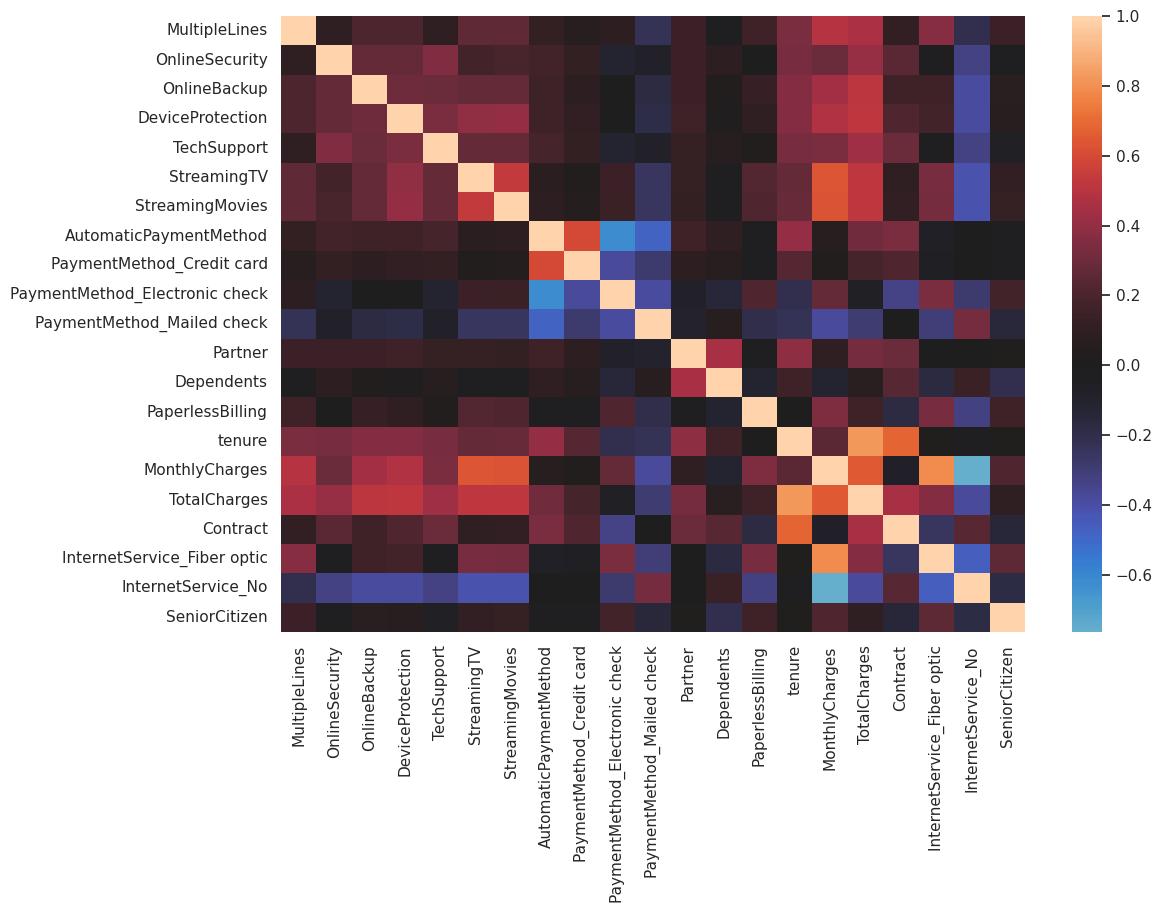

In [30]:
plt.figure(figsize=(12,8))
sns.heatmap(transformed_df.corr(),center=0, annot=False);

In [31]:
# Define the pipeline with SMOTE and RandomForestClassifier
pipeline = ImbPipeline([
    ("preprocessing",final_transformation),
    ('smote', SMOTE(random_state=42)),
    ('classifier', RandomForestClassifier(random_state=42)
     )
])

# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)

# Make predictions on the test data
y_pred = pipeline.predict(X_test)

# Evaluate the model
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[864 169]
 [162 212]]
              precision    recall  f1-score   support

           0       0.84      0.84      0.84      1033
           1       0.56      0.57      0.56       374

    accuracy                           0.76      1407
   macro avg       0.70      0.70      0.70      1407
weighted avg       0.77      0.76      0.77      1407



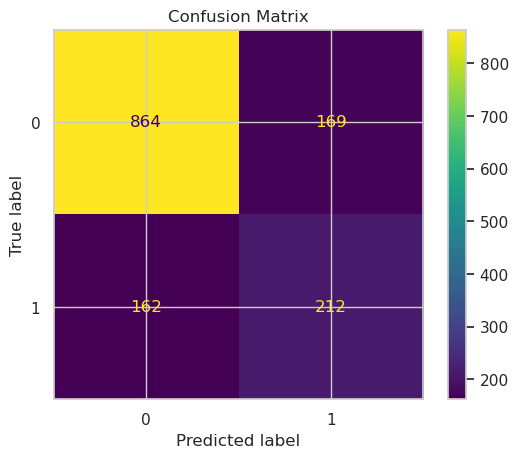

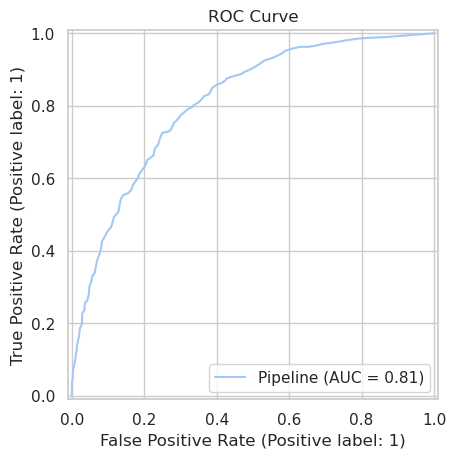

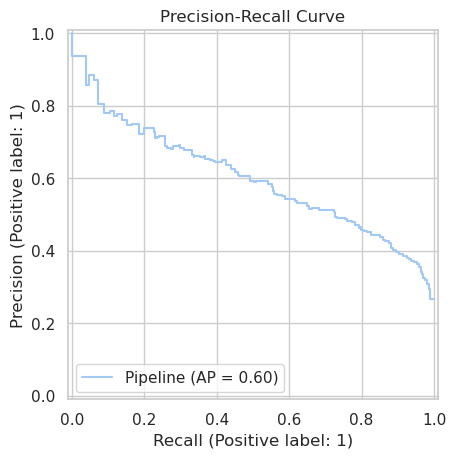

In [32]:
# Plot confusion matrix
ConfusionMatrixDisplay.from_estimator(pipeline, X_test, y_test)
plt.title('Confusion Matrix')
plt.show()

# Plot ROC curve
RocCurveDisplay.from_estimator(pipeline, X_test, y_test)
plt.title('ROC Curve')
plt.show()

# Plot precision-recall curve
PrecisionRecallDisplay.from_estimator(pipeline, X_test, y_test)
plt.title('Precision-Recall Curve')
plt.show()

In [33]:
# Define the Optuna objective function
def objective(trial):
    # Hyperparameter space
    n_estimators = trial.suggest_int('n_estimators', 100, 1000, step=100)
    max_depth = trial.suggest_int('max_depth', 10, 50)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])
    bootstrap = trial.suggest_categorical('bootstrap', [True, False])
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])
    max_leaf_nodes = trial.suggest_int('max_leaf_nodes', 10, 50) if trial.suggest_categorical('max_leaf_nodes_choice', [True, False]) else None
    min_impurity_decrease = trial.suggest_float('min_impurity_decrease', 0.0, 0.05)

    # Define the pipeline with SMOTE and RandomForestClassifier
    pipeline = ImbPipeline([
        ("preprocessing", final_transformation),
        ('smote', SMOTE(random_state=42)),
        ('classifier', RandomForestClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            max_features=max_features,
            bootstrap=bootstrap,
            criterion=criterion,
            max_leaf_nodes=max_leaf_nodes,
            min_impurity_decrease=min_impurity_decrease,
            random_state=42
        ))
    ])

    # Perform cross-validation
    scores = cross_val_score(pipeline, X_train, y_train, cv=3, scoring='accuracy')
    return scores.mean()

In [34]:
# Create the Optuna study and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2024-06-22 21:17:51,402] A new study created in memory with name: no-name-8dea05cc-de69-4ab0-b35c-2a1efd1a69e6
[I 2024-06-22 21:17:52,805] Trial 0 finished with value: 0.7197777777777778 and parameters: {'n_estimators': 300, 'max_depth': 34, 'min_samples_split': 19, 'min_samples_leaf': 6, 'max_features': 'log2', 'bootstrap': False, 'criterion': 'entropy', 'max_leaf_nodes_choice': False, 'min_impurity_decrease': 0.031615555985874275}. Best is trial 0 with value: 0.7197777777777778.
[I 2024-06-22 21:17:55,208] Trial 1 finished with value: 0.7142222222222222 and parameters: {'n_estimators': 600, 'max_depth': 39, 'min_samples_split': 13, 'min_samples_leaf': 9, 'max_features': 'sqrt', 'bootstrap': True, 'criterion': 'entropy', 'max_leaf_nodes_choice': False, 'min_impurity_decrease': 0.046771456539629754}. Best is trial 0 with value: 0.7197777777777778.
[I 2024-06-22 21:17:57,296] Trial 2 finished with value: 0.7202222222222222 and parameters: {'n_estimators': 500, 'max_depth': 10, 'min_s

In [35]:
# Best parameters
print("Best parameters found: ", study.best_params)

# Get the best parameters and remove use_max_leaf_nodes and max_leaf_nodes_choice
best_params = study.best_params
best_params.pop('use_max_leaf_nodes', None)
best_params.pop('max_leaf_nodes_choice', None)

Best parameters found:  {'n_estimators': 800, 'max_depth': 25, 'min_samples_split': 2, 'min_samples_leaf': 7, 'max_features': 'sqrt', 'bootstrap': False, 'criterion': 'gini', 'max_leaf_nodes_choice': False, 'min_impurity_decrease': 3.960503871688263e-05}


False

In [36]:
# Define the pipeline with the best parameters
best_pipeline = ImbPipeline([
    ("preprocessing", final_transformation),
    ('smote', SMOTE(random_state=42)),
    ('classifier', RandomForestClassifier(
        **best_params,
        random_state=42
    ))
])

# Train the best model on the full training data
best_pipeline.fit(X_train, y_train)

# Make predictions on the test data
y_pred = best_pipeline.predict(X_test)

In [37]:
# Evaluate the model
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[821 212]
 [123 251]]
              precision    recall  f1-score   support

           0       0.87      0.79      0.83      1033
           1       0.54      0.67      0.60       374

    accuracy                           0.76      1407
   macro avg       0.71      0.73      0.72      1407
weighted avg       0.78      0.76      0.77      1407



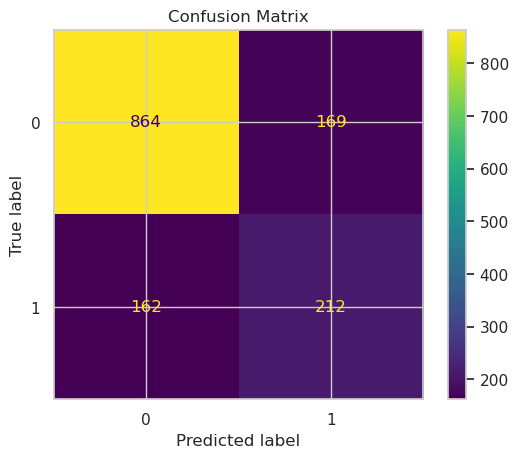

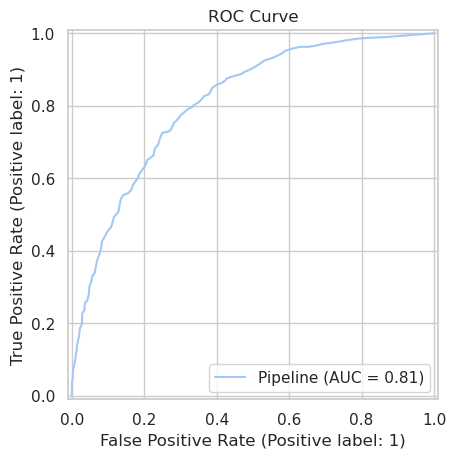

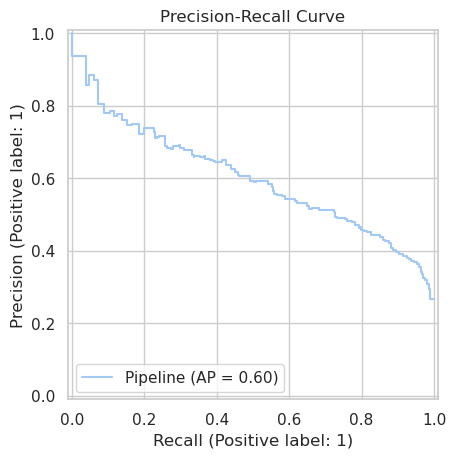

In [38]:
# Plot confusion matrix
ConfusionMatrixDisplay.from_estimator(pipeline, X_test, y_test)
plt.title('Confusion Matrix')
plt.show()

# Plot ROC curve
RocCurveDisplay.from_estimator(pipeline, X_test, y_test)
plt.title('ROC Curve')
plt.show()

# Plot precision-recall curve
PrecisionRecallDisplay.from_estimator(pipeline, X_test, y_test)
plt.title('Precision-Recall Curve')
plt.show()

### Analysis of Model Performance Before and After Hyperparameter Tuning


#### Confusion Matrix

**Before Hyperparameter Tuning**:
```
[[864 169]
 [162 212]]
```
**After Hyperparameter Tuning**:
```
[[814 219]
 [118 256]]
```

#### Classification Report

**Before Hyperparameter Tuning**:
```
              precision    recall  f1-score   support

           0       0.84      0.84      0.84      1033
           1       0.56      0.57      0.56       374

    accuracy                           0.76      1407
   macro avg       0.70      0.70      0.70      1407
weighted avg       0.77      0.76      0.77      1407
```

**After Hyperparameter Tuning**:
```
              precision    recall  f1-score   support

           0       0.87      0.79      0.83      1033
           1       0.54      0.68      0.60       374

    accuracy                           0.76      1407
   macro avg       0.71      0.74      0.72      1407
weighted avg       0.78      0.76      0.77      1407
```

### Conclusion

The hyperparameter tuning resulted in a model that better identifies the minority class (Class 1, Churn) with an improved recall and F1-score for Class 1. However, this came at the cost of a slight decrease in precision for Class 1 and a slight decrease in recall for Class 0. The overall accuracy remained the same, but the model's ability to correctly identify churn (Class 1) improved, which can be crucial depending on the business context. 

These changes suggest that the model is better balanced after hyperparameter tuning, making it more effective for applications where identifying churn is critical.

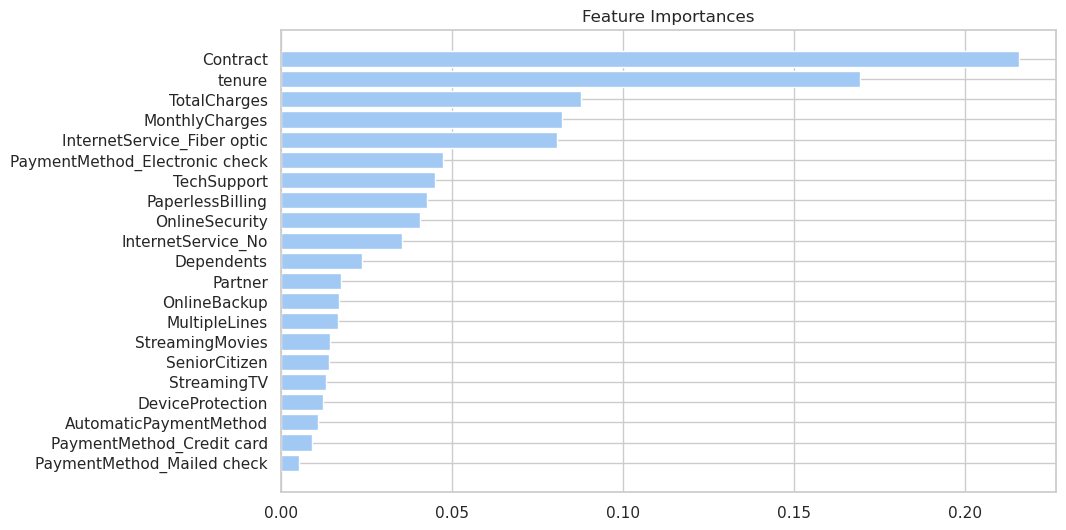

In [39]:
# Extract and plot feature importances
feature_importances = best_pipeline.named_steps['classifier'].feature_importances_
feature_names = best_pipeline.named_steps['preprocessing'].get_feature_names_out()

feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importances
}).sort_values(by='importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['feature'], feature_importance_df['importance'])
plt.title('Feature Importances')
plt.gca().invert_yaxis()  # To display the most important feature at the top
plt.show()

**Interpretation**

The model heavily relies on Contract, tenure, TotalCharges, and MonthlyCharges to predict customer churn.
Features related to service type and additional services (like InternetService_Fiber optic and TechSupport) also play significant roles.
Payment methods and billing preferences (like PaymentMethod_Electronic check and PaperlessBilling) are important but to a lesser extent.
The presence of security and support services (like OnlineSecurity and TechSupport) are noteworthy but less critical.

**Actionable Insights**

To reduce churn, the company might focus on improving customer satisfaction for high-value contracts (like month-to-month contracts).
Enhancing customer experience for customers with higher monthly charges or longer tenures might also help in retaining them.
Offering attractive packages or incentives for customers using fiber optic internet and ensuring high-quality tech support could be effective strategies.